In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import os,sys,json
import pandas as pd
import numpy as np
import sklearn
import scipy as scp
import openpyxl
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sktime as skt

# supress this warning
pd.options.mode.chained_assignment = None

print({pkg.__name__:pkg.__version__ for pkg in [pd, np, scp, sklearn, openpyxl, sns, matplotlib, skt]})

{'pandas': '1.3.4', 'numpy': '1.21.6', 'scipy': '1.7.1', 'sklearn': '1.1.1', 'openpyxl': '3.0.9', 'seaborn': '0.11.1', 'matplotlib': '3.4.3', 'sktime': '0.12.0'}


In [2]:
#importing sys
import sys
  
# adding src to the system path
sys.path.insert(0, '../src')

In [3]:
from ml_pipeline.dataset import load_excel
DATA_PATH = '../input/elevator_failure_prediction.xlsx'

# load the data
raw = load_excel(DATA_PATH, select_sheet='data').set_index('Time')

In [4]:
from ml_pipeline.plotting import plot_subset_of_series, plot_cumsum_of_nulls

### Outlier removal

- in time series data, outlier remove must consider points in the context of the neighbouring points
- we are always only going to consider the window we have for classification (there are alternatives to this)
- examples
- method 1) interquartile range
- method 2) standard deviations

#### i) Outlier examples

- unlikely to be real reading, but rather sensor spikes / malfunctions
- we can only conclude this if we know what we're looking at and apply common sense

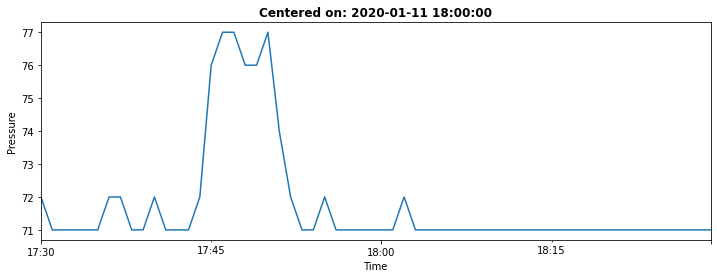

In [5]:
# Pressure jumps from 71 to around 77, for 6 minutes, then falls back. 
# Seems odd, but we can't be sure without knowing more about the workings of the evelator
example_pressure_outlier = plot_subset_of_series(raw.Pressure, index_loc='2020-01-11 18:00:00', w=30)


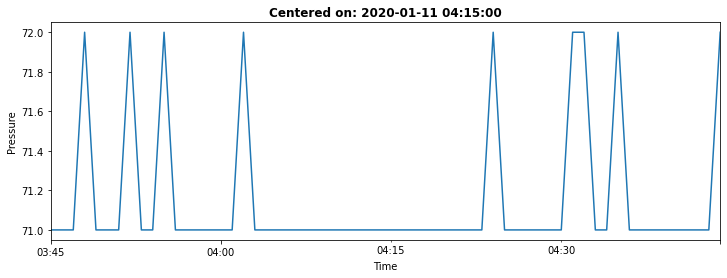

In [6]:
# for comparison here is a normal segment
example_pressure_normal = plot_subset_of_series(raw.Pressure, index_loc='2020-01-11 04:15:00', w=30)

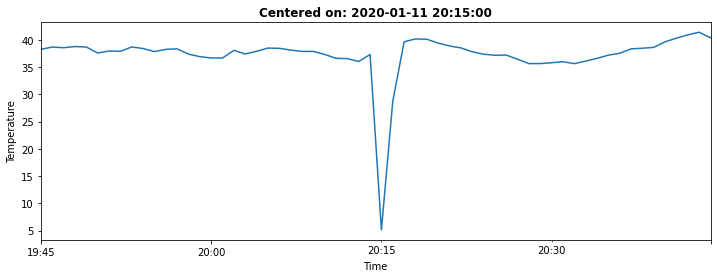

In [7]:
# Temperate drops from around 35 degrees to just 5 degrees, for one minute, then returns
# there is no way that is a genuine Temperature drop, it must be a sensor malfunction
example_temperature_outlier = plot_subset_of_series(raw.Temperature, index_loc='2020-01-11 20:15:00', w=30)

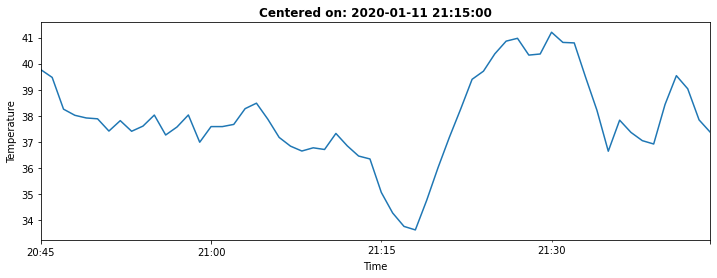

In [8]:
# for comparison here is a normal segment
example_temperature_normal = plot_subset_of_series(raw.Temperature, index_loc='2020-01-11 21:15:00', w=30)

In [9]:
# therse functions for getting lower/upper bounds, then calculating outliers, then plotting
from ml_pipeline.outliers import (compute_bounds_quantiles, compute_bounds_std, compute_outliers)

# plotting function
from ml_pipeline.outliers import (plot_outliers)

#### ii) quartile range method

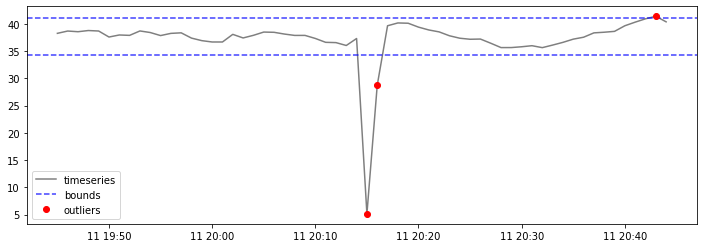

In [10]:
# lets see how this works on our temperature example
plot_outliers(example_temperature_outlier, compute_bounds_quantiles, 
            kwargs={'bounds':[0.25,0.75], 'range_multiplier':1.5})

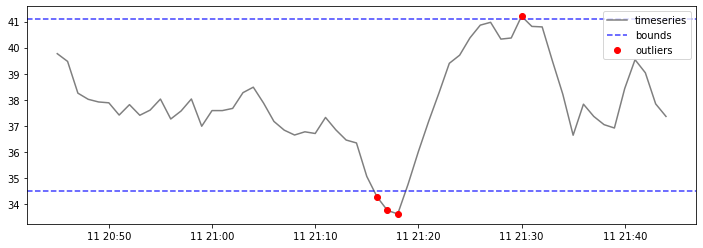

In [11]:
# it does appear to be flagging normal examples
plot_outliers(example_temperature_normal, compute_bounds_quantiles, 
            kwargs={'bounds':[0.25,0.75], 'range_multiplier':1.5})

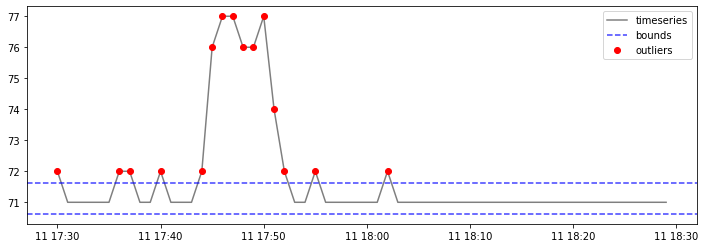

In [12]:
# lets see how this works on our temperature example
plot_outliers(example_pressure_outlier, compute_bounds_quantiles,
            kwargs={'bounds':[0.25,0.75], 'range_multiplier':1.5})

#### iii) Using standard deviation to remove outliers 

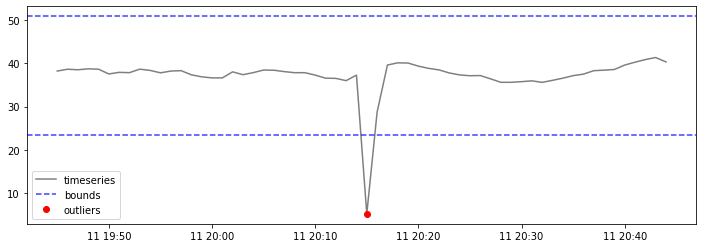

In [13]:
# lets see how this works on our temperature example, it detects the outlier 
plot_outliers(example_temperature_outlier, compute_bounds_std, kwargs={'std_threshold':3})

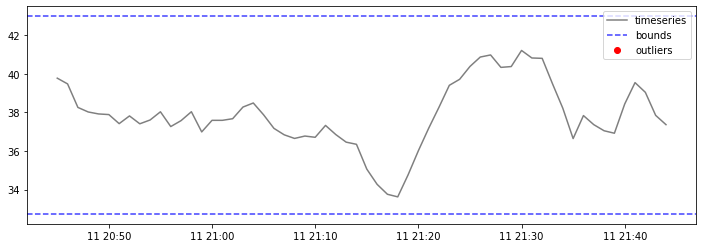

In [14]:
# it also does not detect any outliers during the normal segment, as we would expect
plot_outliers(example_temperature_normal, compute_bounds_std, kwargs={'std_threshold':3})

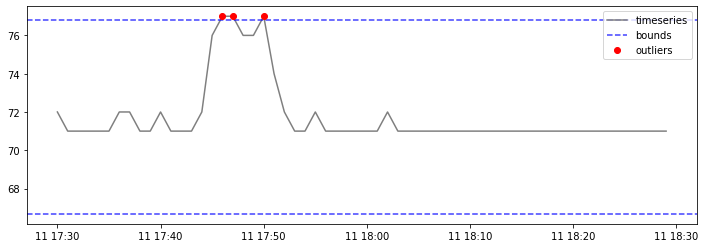

In [15]:
# it also works on our pressure example, it does
plot_outliers(example_pressure_outlier, compute_bounds_std, kwargs={'std_threshold':3})

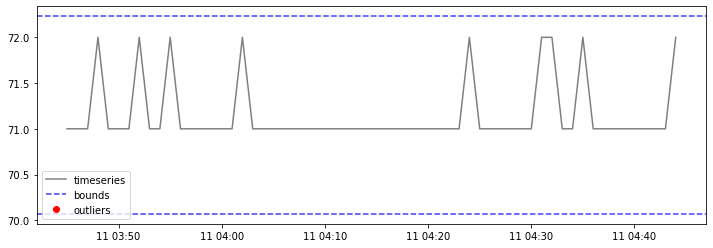

In [16]:
# it also works on our pressure example, it does
plot_outliers(example_pressure_normal, compute_bounds_std, kwargs={'std_threshold':3})

#### iv) how does this affect data when the breakdown occurs

- potentially this could cause problems
- how can we determine outlier from shift in series
- we consider this when we fill in null values

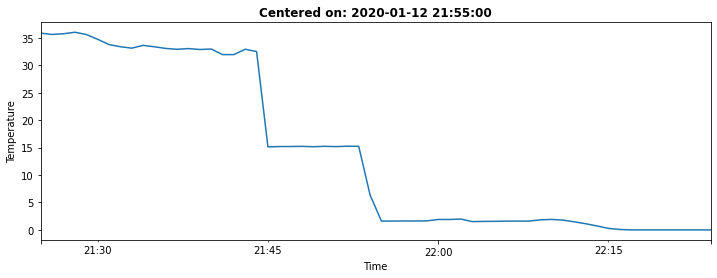

In [17]:
sudden_temperature_drop_centered = plot_subset_of_series(raw.Temperature, index_loc='2020-01-12 21:55:00', w=30)

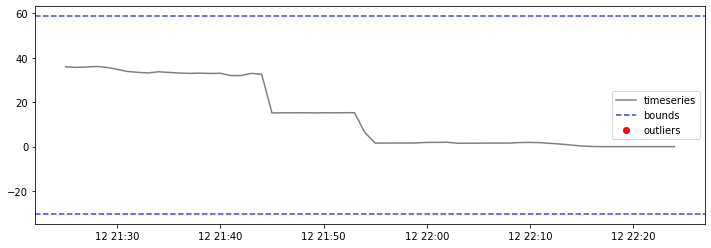

In [18]:
# this is not detected as outlier because we can see the signal has shifted
plot_outliers(sudden_temperature_drop_centered, compute_bounds_std, kwargs={'std_threshold':3})

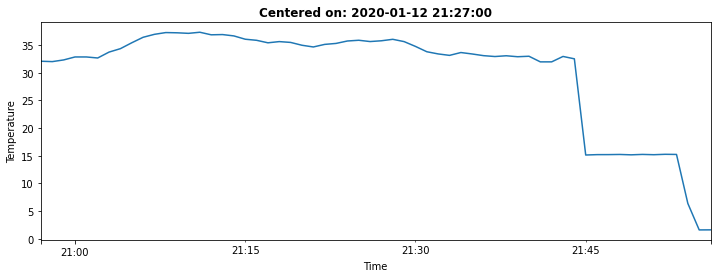

In [19]:
# but consider if the drop only just happened
sudden_temperature_drop_right = plot_subset_of_series(raw.Temperature, index_loc='2020-01-12 21:27:00', w=30)

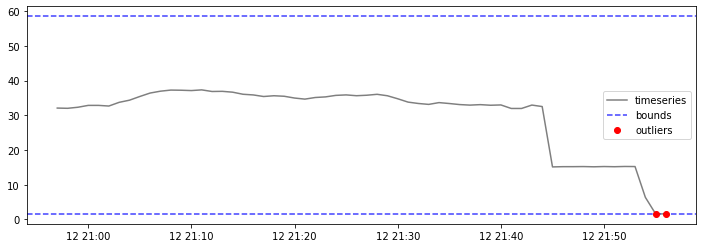

In [20]:
# now we consider this last points outliers, even though they are part of a real shift in the series
plot_outliers(sudden_temperature_drop_right, compute_bounds_std, kwargs={'std_threshold':3})

#### v) how we deal with outliers

- we replace outliers will null, then we will fill them at a later stage
- our compute outliers function flags points as potential outliers, then series with true outliers replaced by nulls
- if we flag a clear cut situation (e.g. temperature blip) we consider this a true outlier becaue it will be straight forward to fill it later
- if we flag points at the very start/end of the window (e.g. temperature drop) we do not consider this a true outlier because we could be losing important information by removing it

In [21]:
# for the example when we flag points in our temperature drop - our function does remove 
sudden_temperature_drop_right_fixed, _ , _ , _ = compute_outliers(sudden_temperature_drop_right, n_passes=1)
pd.concat([sudden_temperature_drop_right.rename('Original'), 
        sudden_temperature_drop_right_fixed.rename('Fixed'), 
        ],axis=1).iloc[-10:]

,Original,Fixed
Time,,
2020-01-12 21:47:00,15.208720,15.208720
2020-01-12 21:48:00,15.236410,15.236410
2020-01-12 21:49:00,15.170040,15.170040
2020-01-12 21:50:00,15.244610,15.244610
2020-01-12 21:51:00,15.191060,15.191060
2020-01-12 21:52:00,15.264060,15.264060
2020-01-12 21:53:00,15.239870,15.239870
2020-01-12 21:54:00,6.379962,6.379962
2020-01-12 21:55:00,1.602259,1.602259


In [22]:
# but for the clear blip example our function does replace this flagged point with a null 
example_temperature_outlier_fixed1, _ , _ , _ = compute_outliers(example_temperature_outlier, n_passes=1)
pd.concat([example_temperature_outlier.rename('Original'), 
            example_temperature_outlier_fixed1.rename('Fixed')
            ],axis=1).iloc[25:35]

,Original,Fixed
Time,,
2020-01-11 20:10:00,37.300880,37.30088
2020-01-11 20:11:00,36.589810,36.58981
2020-01-11 20:12:00,36.537690,36.53769
2020-01-11 20:13:00,36.009990,36.00999
2020-01-11 20:14:00,37.289620,37.28962
2020-01-11 20:15:00,5.127777,NaN
2020-01-11 20:16:00,28.708830,28.70883
2020-01-11 20:17:00,39.627980,39.62798
2020-01-11 20:18:00,40.143830,40.14383


In [23]:
# but note that if we re-run the outlier detection AGAIN after removing that point, we now flag another point
example_temperature_outlier_fixed2, _ , _ , _ = compute_outliers(example_temperature_outlier_fixed1, n_passes=1)

pd.concat([example_temperature_outlier_fixed1.rename('Fixed once'), 
            example_temperature_outlier_fixed2.rename('Fixed twice')
            ],axis=1).iloc[25:35]

,Fixed once,Fixed twice
Time,,
2020-01-11 20:10:00,37.30088,37.30088
2020-01-11 20:11:00,36.58981,36.58981
2020-01-11 20:12:00,36.53769,36.53769
2020-01-11 20:13:00,36.00999,36.00999
2020-01-11 20:14:00,37.28962,37.28962
2020-01-11 20:15:00,NaN,NaN
2020-01-11 20:16:00,28.70883,NaN
2020-01-11 20:17:00,39.62798,39.62798
2020-01-11 20:18:00,40.14383,40.14383


In [24]:
# we can do this automatically with our function using the n_passes arg
example_temperature_outlier_fixed2, _ , _ , _ = compute_outliers(example_temperature_outlier, n_passes=2)
pd.concat([example_temperature_outlier.rename('Fixed once'), 
            example_temperature_outlier_fixed2.rename('Fixed twice')
            ],axis=1).iloc[25:35]

,Fixed once,Fixed twice
Time,,
2020-01-11 20:10:00,37.300880,37.30088
2020-01-11 20:11:00,36.589810,36.58981
2020-01-11 20:12:00,36.537690,36.53769
2020-01-11 20:13:00,36.009990,36.00999
2020-01-11 20:14:00,37.289620,37.28962
2020-01-11 20:15:00,5.127777,NaN
2020-01-11 20:16:00,28.708830,NaN
2020-01-11 20:17:00,39.627980,39.62798
2020-01-11 20:18:00,40.143830,40.14383


### Filling missing values

- We need to fill misisng values if the raw data has holes, or if we have removed values as outlier
- If missing values are at the very start or very end of the series, we consider them differently 

In [25]:
# recall that two of our columns had missing values
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44640 entries, 2020-01-01 00:00:00 to 2020-01-31 23:59:00
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  44631 non-null  float64
 1   Humidity     44640 non-null  float64
 2   RPM          44640 non-null  float64
 3   Vibrations   44640 non-null  float64
 4   Pressure     44640 non-null  float64
 5   Sensor1      44640 non-null  float64
 6   Sensor2      40586 non-null  float64
 7   Sensor3      44640 non-null  float64
 8   Sensor4      44640 non-null  float64
 9   Sensor5      44640 non-null  float64
 10  Sensor6      44640 non-null  float64
 11  Status       44640 non-null  float64
dtypes: float64(12)
memory usage: 5.4 MB


#### i) Examples of missing from raw data (Temperature & Sensor2)

In [26]:
from ml_pipeline.plotting import plot_subset_of_series, plot_cumsum_of_nulls

In [27]:
# examine spread of Temperature nulls, there are 2 groups
raw[raw.Temperature.isna()].index

DatetimeIndex(['2020-01-18 10:32:00', '2020-01-27 17:48:00',
               '2020-01-27 17:49:00', '2020-01-27 17:50:00',
               '2020-01-27 17:51:00', '2020-01-27 17:52:00',
               '2020-01-27 17:53:00', '2020-01-27 17:54:00',
               '2020-01-27 17:55:00'],
              dtype='datetime64[ns]', name='Time', freq=None)

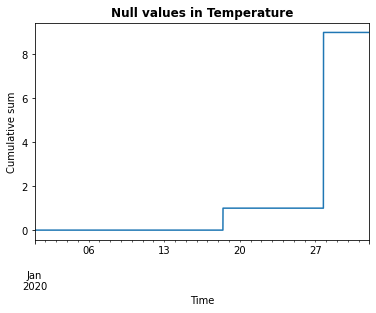

In [28]:
# another way to look at this is cumsum, we see 1 on its own, then 8 in a row 
plot_cumsum_of_nulls(raw.Temperature)

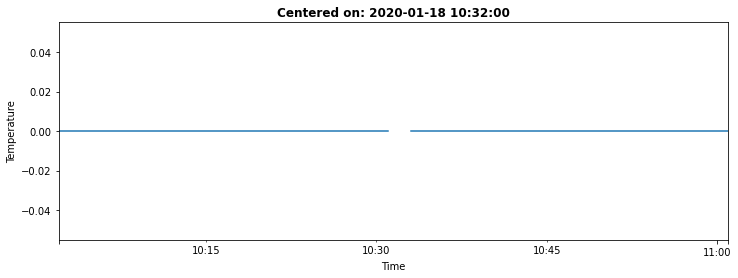

In [29]:
# this seems pretty clear that we could interpolate
ts = plot_subset_of_series(raw.Temperature, '2020-01-18 10:32:00', w=30)

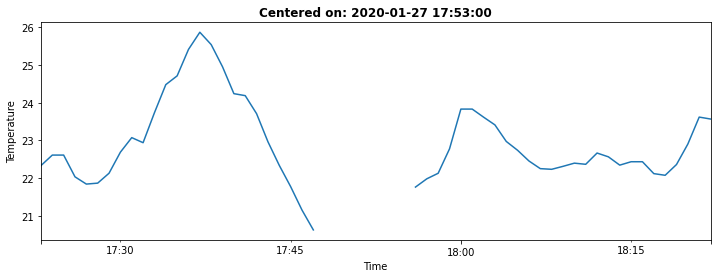

In [30]:
# this also looks like it could be interpolated fairly reliably
ts = plot_subset_of_series(raw.Temperature, '2020-01-27 17:53:00', w=30)

In [31]:
# next lets look at Sensor2 nulls, it is harder to see what is going on becuse there are so many
raw[raw.Sensor2.isna()].index

DatetimeIndex(['2020-01-12 21:56:00', '2020-01-12 21:57:00',
               '2020-01-12 21:58:00', '2020-01-12 21:59:00',
               '2020-01-12 22:00:00', '2020-01-12 22:01:00',
               '2020-01-12 22:02:00', '2020-01-12 22:03:00',
               '2020-01-12 22:04:00', '2020-01-12 22:05:00',
               ...
               '2020-01-20 04:11:00', '2020-01-20 04:12:00',
               '2020-01-20 04:13:00', '2020-01-20 04:14:00',
               '2020-01-20 04:15:00', '2020-01-20 04:16:00',
               '2020-01-20 04:17:00', '2020-01-20 04:18:00',
               '2020-01-20 04:19:00', '2020-01-20 04:20:00'],
              dtype='datetime64[ns]', name='Time', length=4054, freq=None)

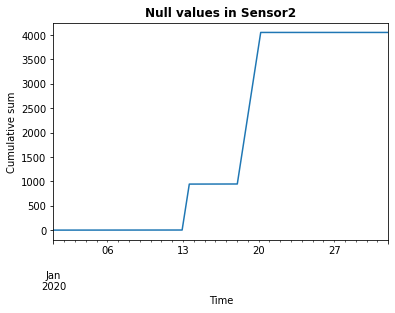

In [32]:
# cumsum plot helps up see what is going on
plot_cumsum_of_nulls(raw.Sensor2)

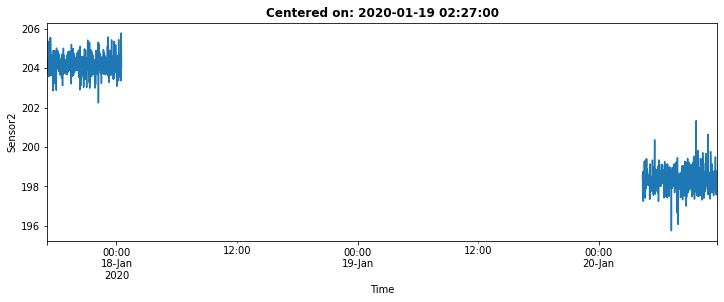

In [33]:
# simple interpolation will not give a good answer here
# also we have hundreds of missing consecutive values, so many of our windows of 30 or 60 will be entirely empty
# if we have a window of 30 or 60, there will be many windows that are entirely empty
ts = plot_subset_of_series(raw.Sensor2, '2020-01-19 02:27:00', w=2000)

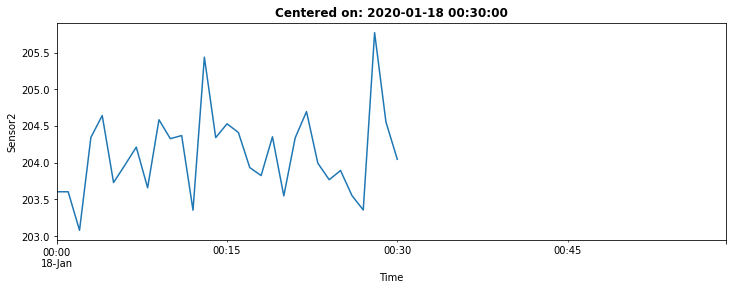

In [34]:
# this is one training window that we can't simply interpolate
example_sensor2_end_null = plot_subset_of_series(raw.Sensor2, '2020-01-18 00:30:00', w=30)


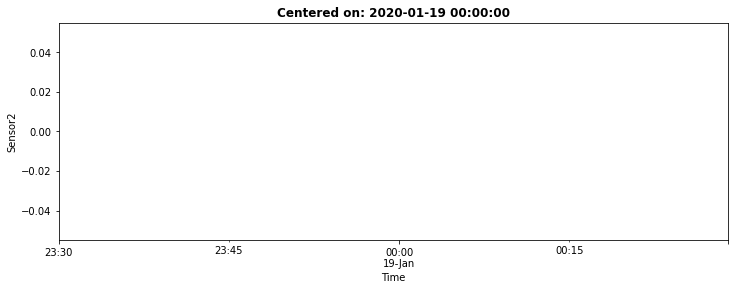

In [35]:
# this is an entirely empty training window
example_sensor2_all_null = plot_subset_of_series(raw.Sensor2, '2020-01-19 00:00:00', w=30)

#### ii) Generalised filling function

- We want generalised approach which we apply to all series (we don't know what will be missing in the future)
- For 'inner' nulls we interpolate linearly between surrounding points
- For 'outer' nulls we replicate the first/last value 
- While outer replicate might not be realistic, this does give the model information (i.e. zero variance)
- If the entire series is all nulls, we replace with preset value (a 'prior' for null values)

In [36]:
# this applies the filling described above
from ml_pipeline.outliers import fill_nulls

# this function visallises the above 
from ml_pipeline.outliers import plot_with_nulls_filled

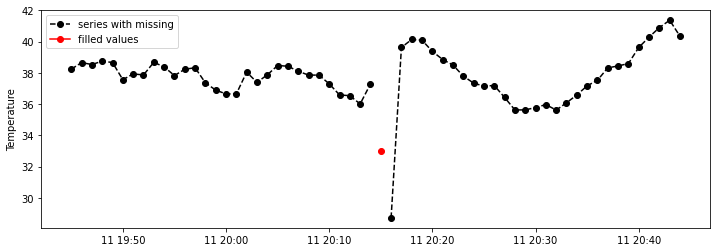

In [37]:
# here is the result of filling when we do 1 pass on our temperature blip example
filled = plot_with_nulls_filled(example_temperature_outlier_fixed1)

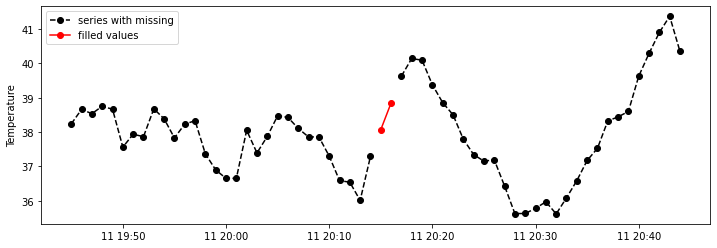

In [38]:
# here is the result of filling when we do 2 passes on our temperature blip example
filled = plot_with_nulls_filled(example_temperature_outlier_fixed2)

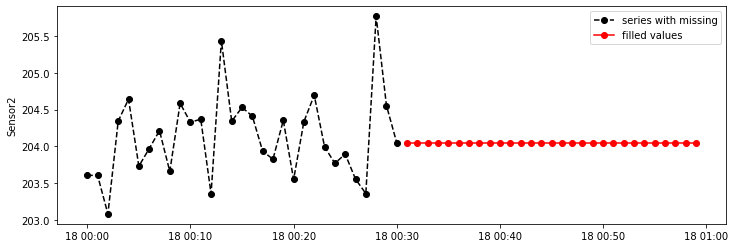

In [39]:
# this is how we deal with the end of the series missing
filled = plot_with_nulls_filled(example_sensor2_end_null)

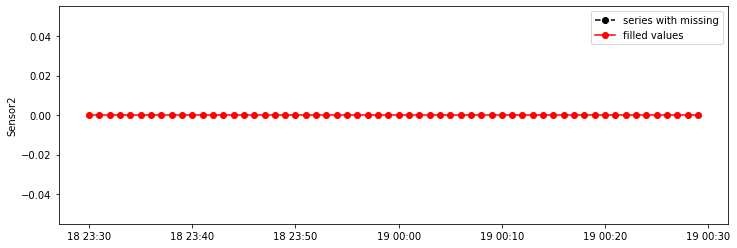

In [40]:
# this is how we deal with everything missing
filled = plot_with_nulls_filled(example_sensor2_all_null)

### Frequency filtering 

- waveforms have amplitudes and frequencies
- a time series can be comprised of multiple waveforms
- we can filter our certain frequencies if we consider them noise (maximising the signal to noise ratio)

#### i) Terminology

In [41]:
from ml_pipeline.filtering import generate_sinewave, plot_waveform

<AxesSubplot:xlabel='Minutes', ylabel='Amplitude'>

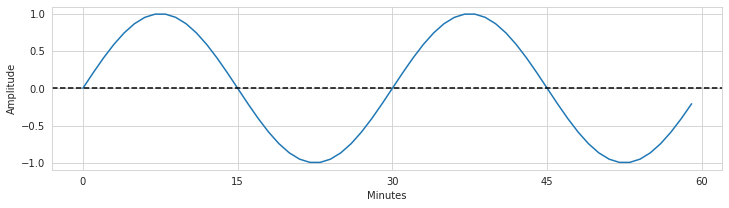

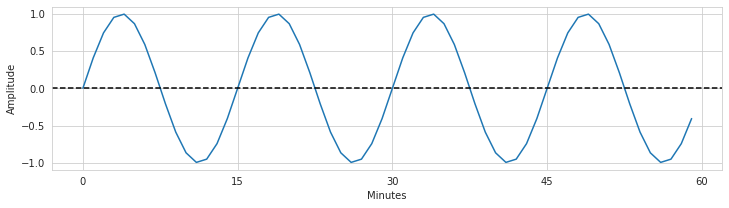

In [42]:
# Frequency
signal_1h = generate_sinewave(frequency = 2, amplitude = 1)
signal_2h = generate_sinewave(frequency = 4, amplitude = 1)
plot_waveform(signal_1h)
plot_waveform(signal_2h)


<AxesSubplot:xlabel='Minutes', ylabel='Amplitude'>

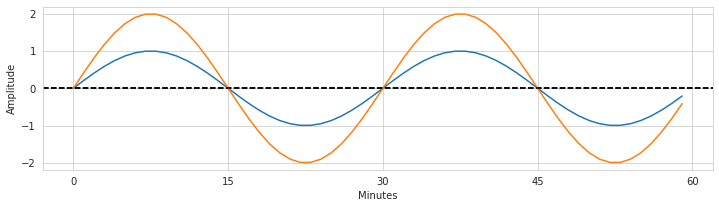

In [43]:
# Amplitude
signal_1a = generate_sinewave(frequency = 2, amplitude = 1)
signal_4a = generate_sinewave(frequency = 2, amplitude = 2)
ax = plot_waveform(signal_1a)
plot_waveform(signal_4a, ax = ax )

<AxesSubplot:xlabel='Minutes', ylabel='Amplitude'>

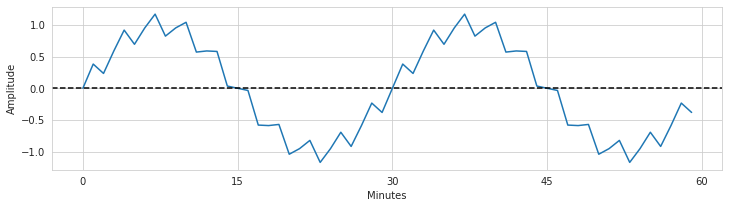

In [44]:
# Series comprised of two waveforms (e.g. high frequency noise added to main signal)
signal = generate_sinewave(frequency = 2, amplitude = 1)
noise = generate_sinewave(frequency = 20, amplitude = 0.2)
signal_noise_predictable = signal + noise
plot_waveform(signal_noise_predictable)

<AxesSubplot:xlabel='Minutes', ylabel='Amplitude'>

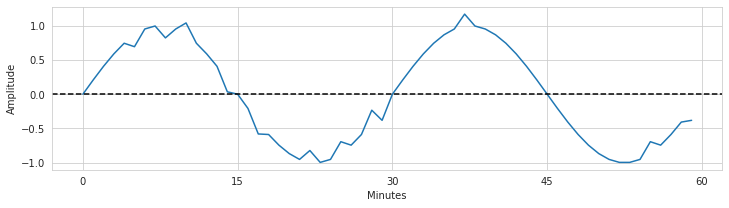

In [45]:
# another trickier example where the noise occurs randomly
random_noise = noise * (np.random.random(len(noise)) > 0.8)
signal_noise_random = signal + random_noise
plot_waveform(signal_noise_random)

#### ii) Series decomposition

- using scipy.fft to translate to frequency domain
- this is called decomposing the series

In [46]:
from ml_pipeline.filtering import decompose_series, plot_signal_frequency_domain

In [47]:
# this performs a fourier transforamtion of the series into the frequency domain
# index = frequency bands, values = power at that band
decompose_series(signal_noise_predictable, absolute=True)

0.0     6.772360e-15
1.0     6.853762e-15
2.0     3.000000e+01
3.0     9.673571e-15
4.0     6.108792e-15
5.0     6.181959e-15
6.0     3.241677e-15
7.0     5.793522e-15
8.0     2.471411e-15
9.0     3.073608e-15
10.0    8.045862e-15
11.0    5.904836e-15
12.0    4.172521e-15
13.0    1.375043e-15
14.0    2.850559e-15
15.0    5.015702e-15
16.0    3.899612e-15
17.0    4.563267e-15
18.0    5.367173e-15
19.0    1.338912e-14
20.0    6.000000e+00
21.0    1.656750e-14
22.0    8.251967e-15
23.0    7.830470e-15
24.0    3.149254e-15
25.0    5.287856e-15
26.0    3.279641e-15
27.0    2.883180e-15
28.0    7.266504e-16
29.0    2.953746e-15
30.0    5.440093e-15
Name: decomposition, dtype: float64

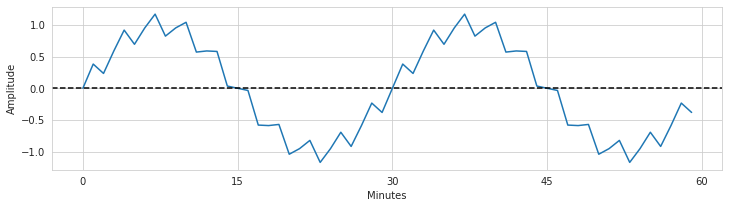

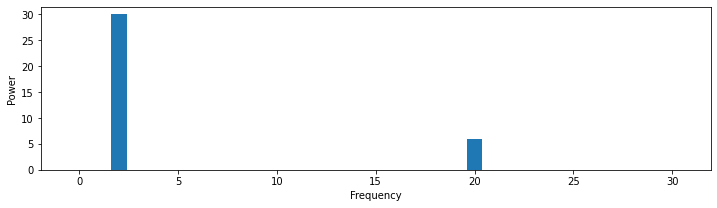

In [48]:
# frequency and time domain for predictable noise
plot_waveform(signal + noise)
fd = decompose_series(signal_noise_predictable, sample_rate=60, absolute=True)
plot_signal_frequency_domain(fd)

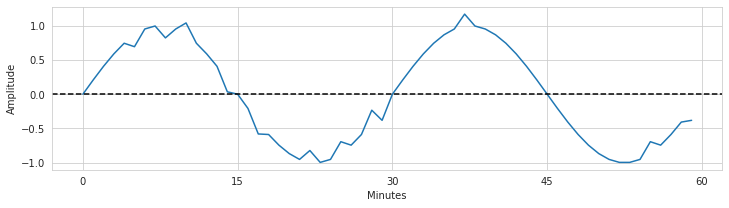

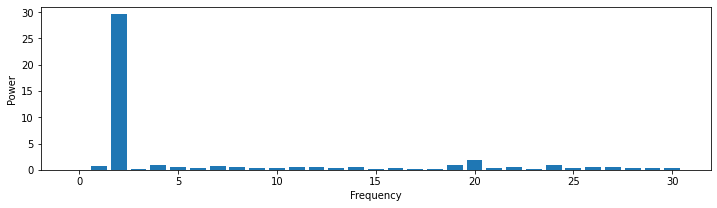

In [49]:
# frequency and time domain for unpredictable noise
plot_waveform(signal + random_noise)
fd = decompose_series(signal + random_noise, sample_rate=60, absolute=True)
plot_signal_frequency_domain(fd)

#### iii) Filtering frequencies

- we can remove certain frequencies then reconstruct the signal
- 'low pass' filters: only keeps frequencies below a certain threshold
- 'high pass' filters: only keeps frequencies above a certain threhold
- 'band pass' filters: only keeps frequences between two thresholds
- 'notch' filter: removes frequencies inbetween two thresholds

In [50]:
# this function can remove frequencies above or below give thresholds
from ml_pipeline.filtering import filter_frequencies

<AxesSubplot:xlabel='Minutes', ylabel='Amplitude'>

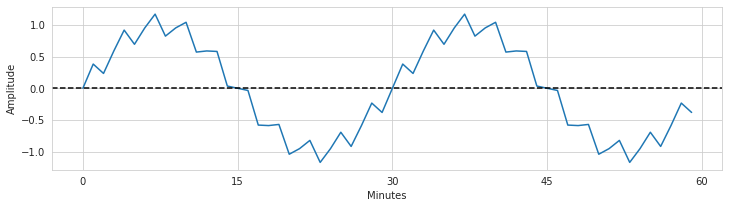

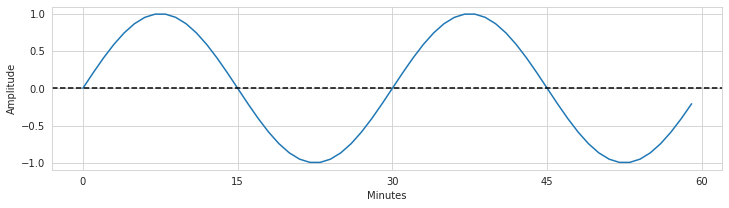

In [51]:
# we can perfectly recover the original signal when noise is predictable
signal_noise_predictable_clean = filter_frequencies(signal_noise_predictable, max_freq=10)
plot_waveform(signal_noise_predictable)
plot_waveform(signal_noise_predictable_clean)

<AxesSubplot:xlabel='Minutes', ylabel='Amplitude'>

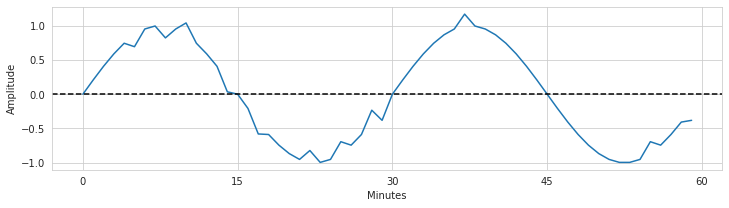

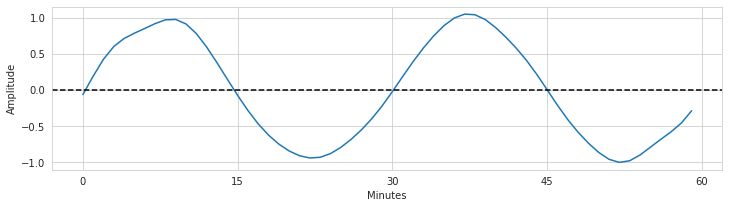

In [52]:
# we can also do it for random noise but we don't recover a perfect signal
signal_noise_random_clean = filter_frequencies(signal_noise_random, max_freq=10)
plot_waveform(signal_noise_random)
plot_waveform(signal_noise_random_clean)

#### iv) examples from our data


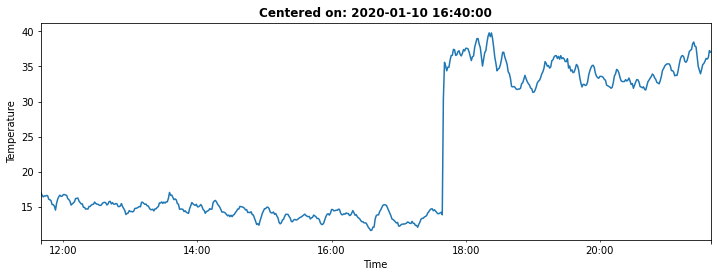

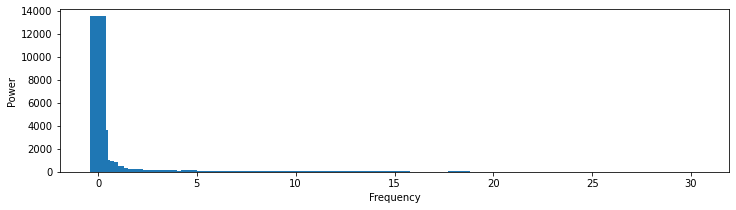

In [53]:
# get an example from our dataset
eg_temp = plot_subset_of_series(raw.Temperature, index_loc='2020-01-10 16:40:00', w=300)

# there is no clear pattern in the frequency domain
fd = decompose_series(eg_temp, sample_rate=60, absolute=True)
plot_signal_frequency_domain(fd)

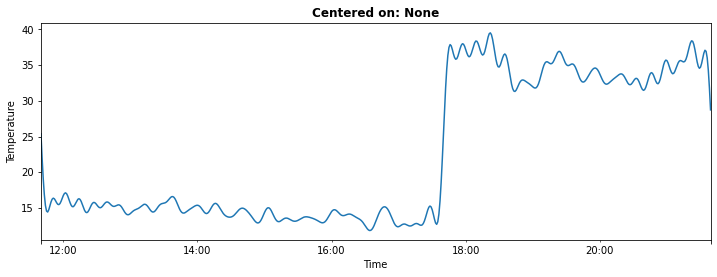

In [54]:
# filtering will smooth out the signal, but does this help us?
eg_temp_clean = filter_frequencies(eg_temp, max_freq=5)
eg_temp_clean = plot_subset_of_series(eg_temp_clean)

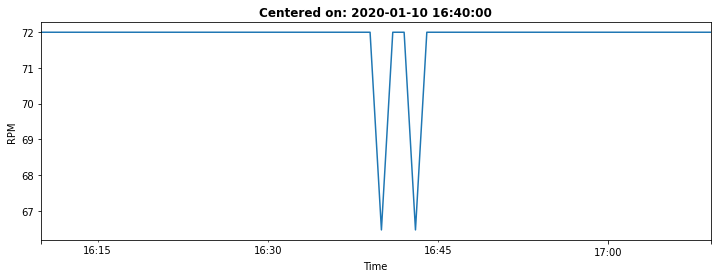

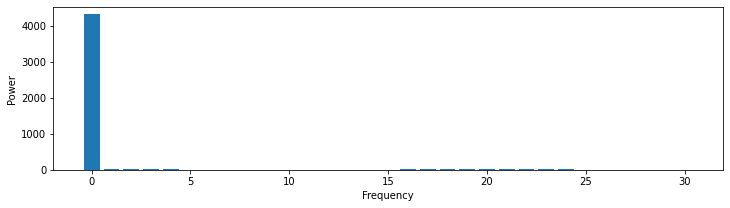

In [55]:
# another example using RPM
eg_rpm = plot_subset_of_series(raw.RPM, index_loc='2020-01-10 16:40:00', w=30)
fd = decompose_series(eg_rpm, sample_rate=60, absolute=True)
plot_signal_frequency_domain(fd)

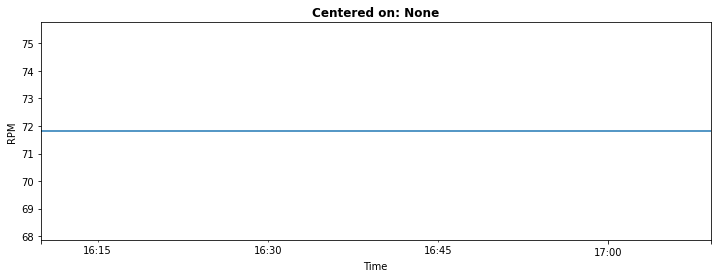

In [56]:
# we can filter out the blips, but note the RPM is now just below 72
eg_rpm_clean = filter_frequencies(eg_rpm, max_freq=0.4)
eg_rpm_clean = plot_subset_of_series(eg_rpm_clean)

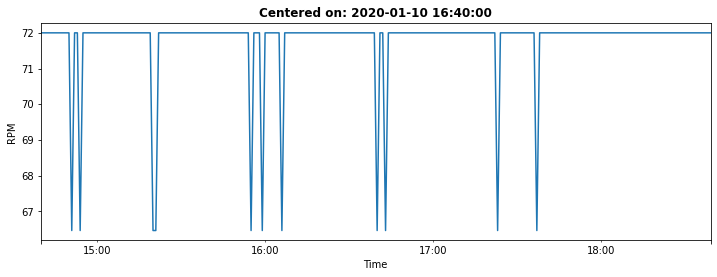

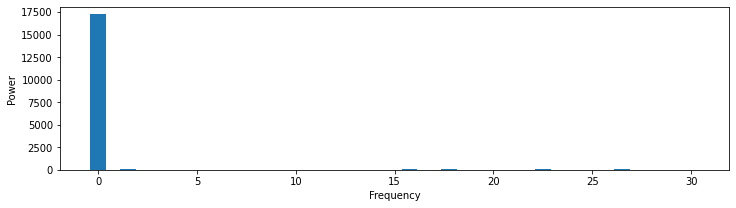

In [57]:
# also let us seem if we get a similar result doing the same thing to a larger section of the RPM series
eg_rpm = plot_subset_of_series(raw.RPM, index_loc='2020-01-10 16:40:00', w=120)
fd = decompose_series(eg_rpm, sample_rate=60, absolute=True)
plot_signal_frequency_domain(fd)

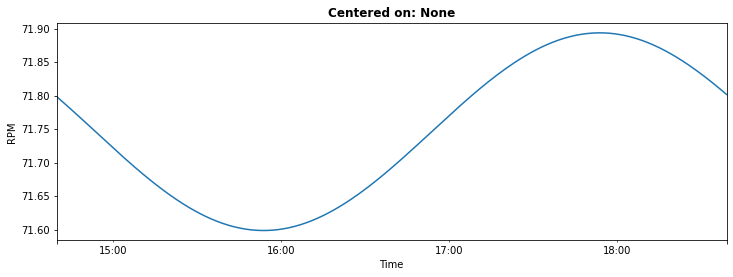

In [58]:
# now we have a completely different result
# it doesn't look like there is much value to using frequency filtering on this dataset
eg_rpm_clean = filter_frequencies(eg_rpm, max_freq=0.4)
eg_rpm_clean = plot_subset_of_series(eg_rpm_clean)